In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')




In [22]:
import pandas as pd

df = pd.read_csv("hour.csv")
X_train = df.drop('cnt', axis=1)
y_train = df['cnt']
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


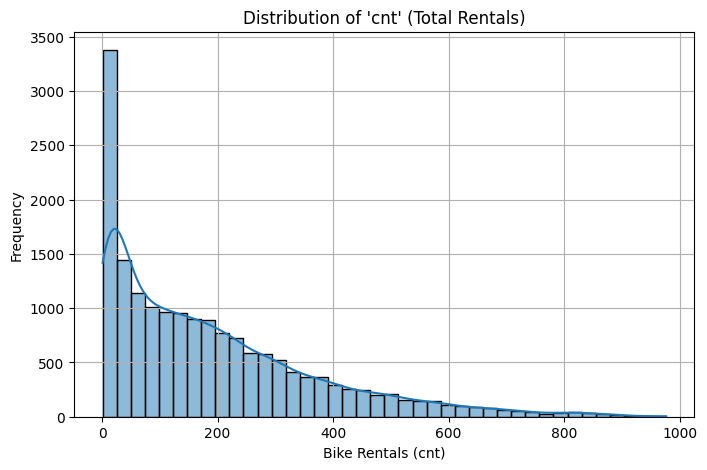

Skewness of 'cnt': 1.28


In [23]:
# Distribution plot
plt.figure(figsize=(8, 5))
sns.histplot(df['cnt'], bins=40, kde=True)
plt.title("Distribution of 'cnt' (Total Rentals)")
plt.xlabel("Bike Rentals (cnt)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Skewness
cnt_skewness = df['cnt'].skew()
print(f"Skewness of 'cnt': {cnt_skewness:.2f}")


Right skewed distriutions
most of the data is concentrated on the left side,
There are lot of instances with rentals between 0 and 100.
There are some instances where rentals go above 600 plus ,indicating those are rare high demand hours.


Peak hours get very high rentals.
Because the data is not normally distributed,some models like linear regression might not perform as well unless we use models that are robust to skewed targets (like Random Forest, XGBoost).

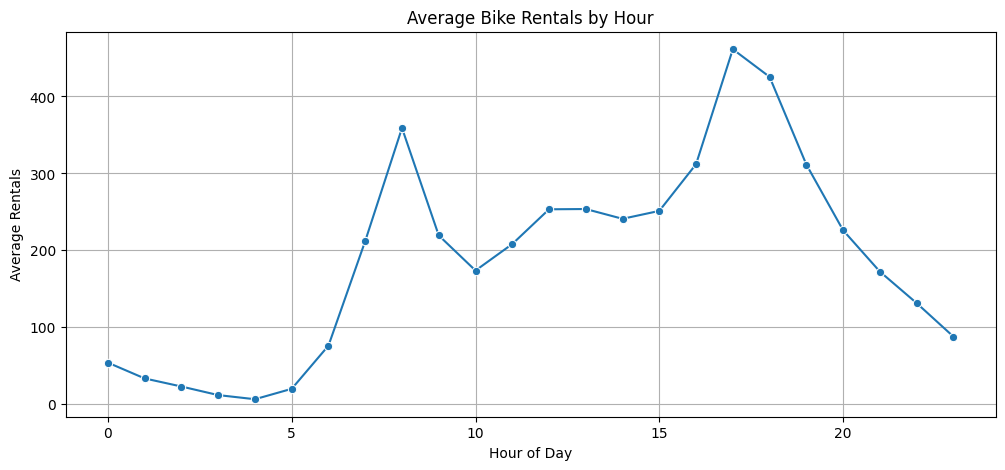

In [24]:
# Average rentals by hour
plt.figure(figsize=(12, 5))
sns.lineplot(data=df.groupby("hr")["cnt"].mean(), marker="o")
plt.title("Average Bike Rentals by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Rentals")
plt.grid(True)
plt.show()



X-axis: Bike Rentals (cnt)
Y-axis: Frequency (number of observations)

Interpretation:
The spread is skewed to the right, which suggests that rental counts are mostly low.Large numbers of the instances have rental counts between (0,100), peaking very early.
As the number of rentals increases, the frequency decreases sharply.The implication is that rented hours are generally not very high, but could still be very high (long tail).

Implication for modeling:
This distribution can be transformed (as log) and may be beneficial when using linear models.we may notice that with tree-based models, like Random Forest or XGBoost, skewed distributions aren’t much of a problem.

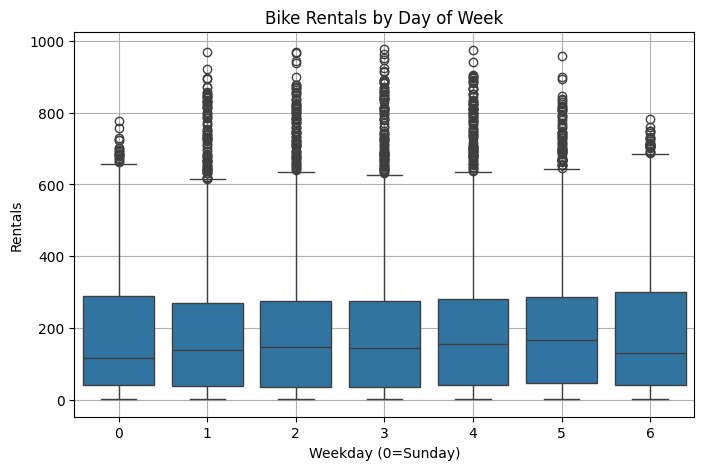

In [25]:
# Boxplot by weekday
plt.figure(figsize=(8, 5))
sns.boxplot(x="weekday", y="cnt", data=df)
plt.title("Bike Rentals by Day of Week")
plt.xlabel("Weekday (0=Sunday)")
plt.ylabel("Rentals")
plt.grid(True)
plt.show()

X-axis: Hour of Day (0 to 23)
Y-axis: Average Rentals

Interpretation:

There are two clear rental peaks:
Morning peak (8 AM): This is probably the time when people are commuting to work or school.
Evening peak (5–6 PM): Represents people returning home.
Between the hours of 2 AM and 5 AM is when rental activity is at its lowest - likely reflecting common sleep times.
The time-of-day effect on rentals is clearly evident.

Implication for modeling:

Hour is a highly informative feature.
Could potentially gain from things like feature engineering such as creating binary rush hour feature; e.g., 7 to 9 AM and 5 to 9 PM

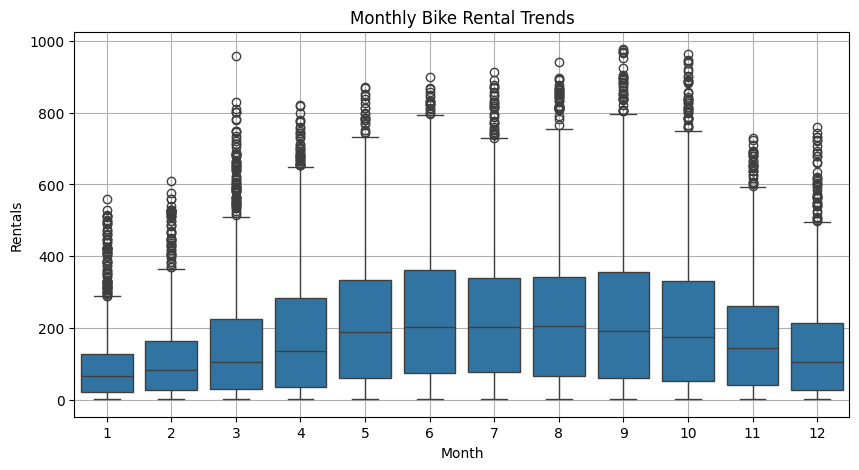

In [26]:
# Rentals by month
plt.figure(figsize=(10, 5))
sns.boxplot(x="mnth", y="cnt", data=df)
plt.title("Monthly Bike Rental Trends")
plt.xlabel("Month")
plt.ylabel("Rentals")
plt.grid(True)
plt.show()

The box plot chart shows "Monthly Bike Rental Trends". It represents the range of bicycle rentals made in each month of the year from January (1) to December (12). Y represents the count of rentals, ranging from 0 to 1000.

Each box plot portrays a monthly summary:
-Median: The mark above the body of the box, showing the rental that is closest to the middle.
Quartiles - The box edges display the range between the 25th and 75th percentiles.
Outliers denote the points outside the whiskers, visualizing unusual rental counts.

The chart illustrates the seasonal nature of rentals, more active months are exchanged with less active ones. The chart is useful for recognizing the trends, understanding in which season bikes are most popular and understanding the months with the most unusual rental patterns.

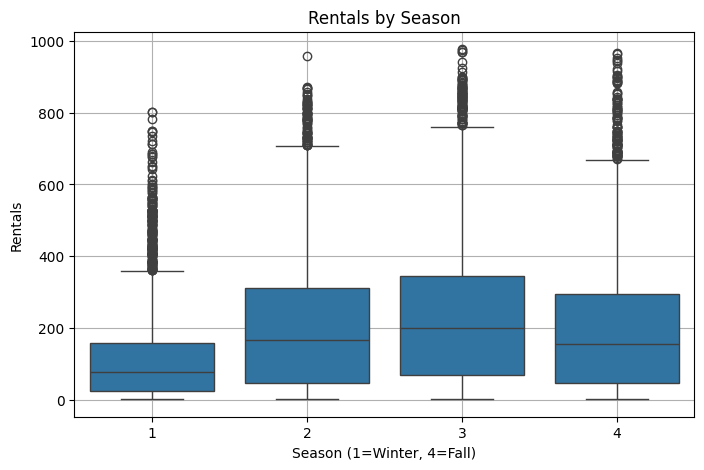

In [27]:

# Rentals by season
plt.figure(figsize=(8, 5))
sns.boxplot(x="season", y="cnt", data=df)
plt.title("Rentals by Season")
plt.xlabel("Season (1=Winter, 4=Fall)")
plt.ylabel("Rentals")
plt.grid(True)
plt.show()

This box plots shows the rentals of bike in each season

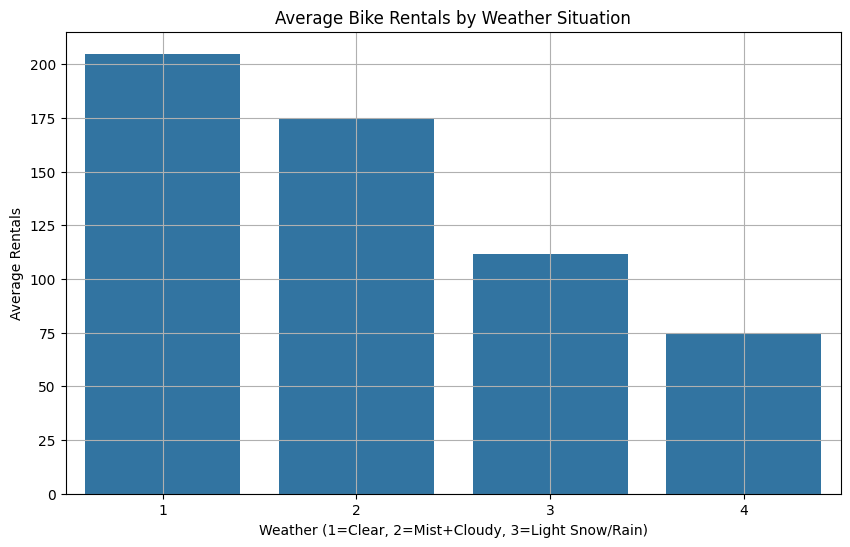

In [28]:
# Weather analysis
plt.figure(figsize=(10, 6))
weather_rentals = df.groupby('weathersit')['cnt'].mean()
sns.barplot(x=weather_rentals.index, y=weather_rentals.values)
plt.title('Average Bike Rentals by Weather Situation')
plt.xlabel('Weather (1=Clear, 2=Mist+Cloudy, 3=Light Snow/Rain)')
plt.ylabel('Average Rentals')
plt.grid(True)
plt.show()

The histogram shows the average bike rentals during each weather situation.we can see that when weather is clear the avg bike rentals is high and when the weather is lightsnow or rain the avg bike rentals id low.

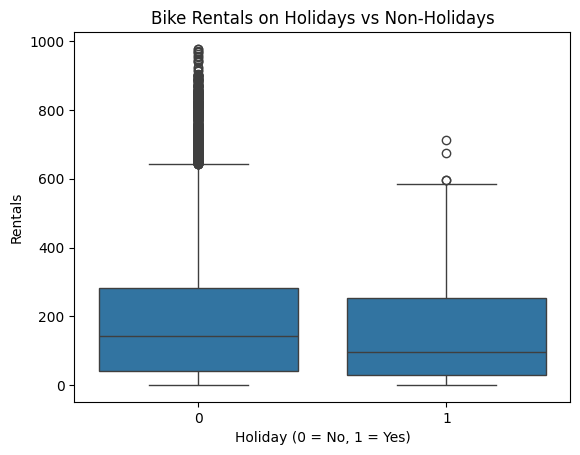

In [29]:
# Holiday vs Non-holiday
sns.boxplot(x="holiday", y="cnt", data=df)
plt.title("Bike Rentals on Holidays vs Non-Holidays")
plt.xlabel("Holiday (0 = No, 1 = Yes)")
plt.ylabel("Rentals")
plt.show()


when there is no holiday the rental of bike is high

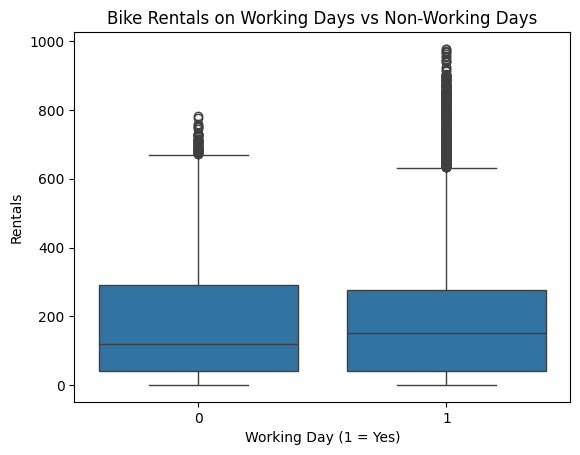

In [30]:
# Working day vs Weekend/holiday
sns.boxplot(x="workingday", y="cnt", data=df)
plt.title("Bike Rentals on Working Days vs Non-Working Days")
plt.xlabel("Working Day (1 = Yes)")
plt.ylabel("Rentals")
plt.show()

when it a working day the rental is high

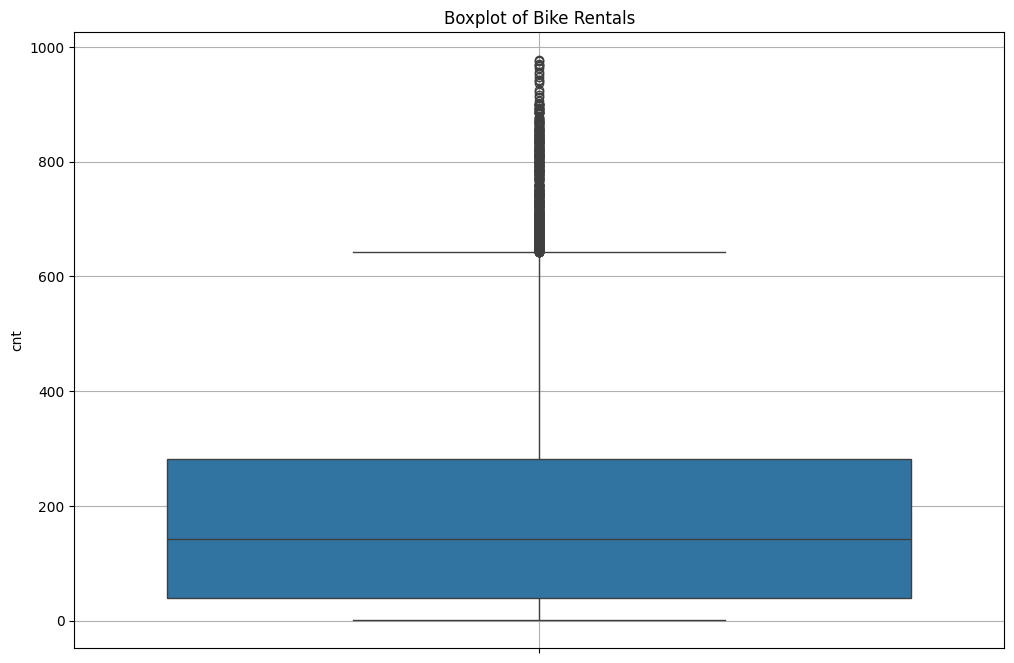

In [31]:
# Outliers detection
plt.figure(figsize=(12, 8))
sns.boxplot(df['cnt'])
plt.title('Boxplot of Bike Rentals')
plt.grid(True)
plt.show()

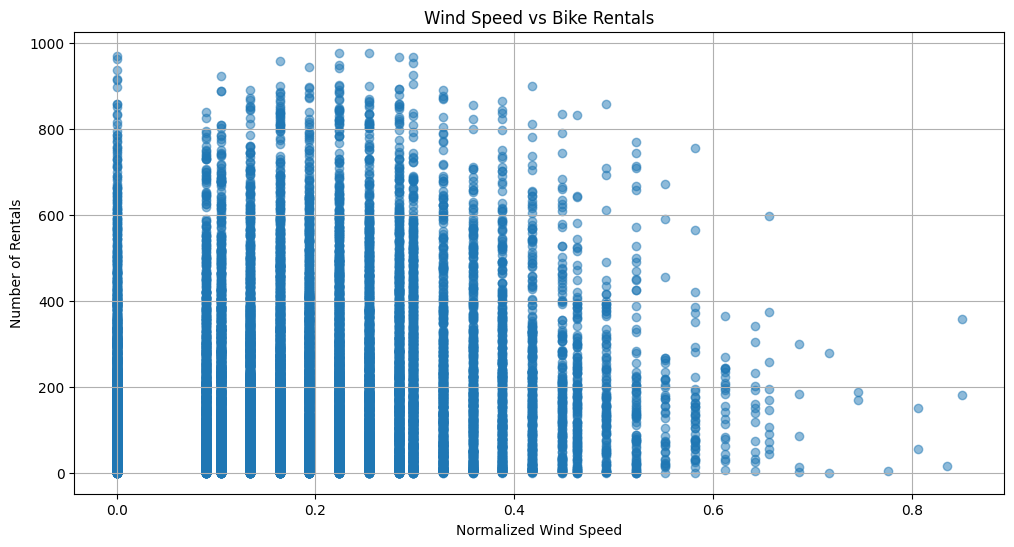

In [32]:


# Wind speed vs rentals
plt.figure(figsize=(12, 6))
plt.scatter(df['windspeed'], df['cnt'], alpha=0.5)
plt.title('Wind Speed vs Bike Rentals')
plt.xlabel('Normalized Wind Speed')
plt.ylabel('Number of Rentals')
plt.grid(True)
plt.show()




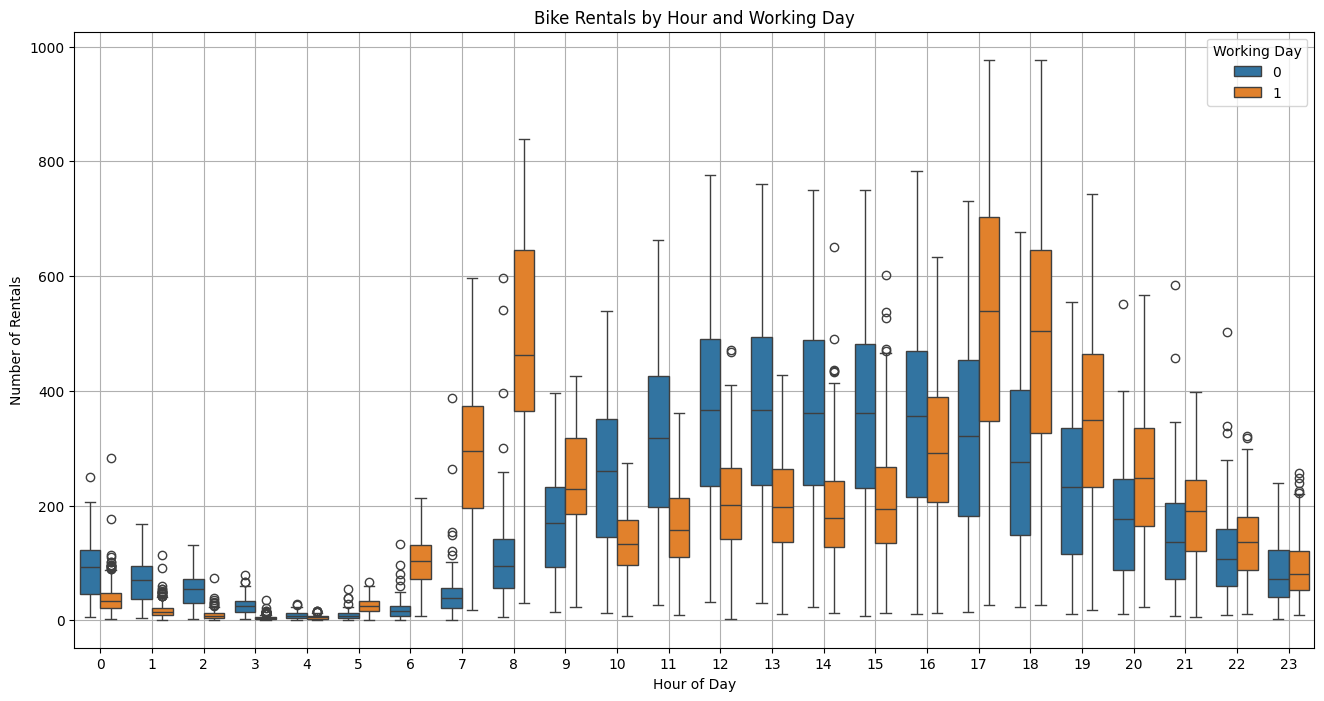

In [33]:
# Boxplot of rentals by hour and workingday
plt.figure(figsize=(16, 8))
sns.boxplot(x='hr', y='cnt', hue='workingday', data=df)
plt.title('Bike Rentals by Hour and Working Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rentals')
plt.legend(title='Working Day')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

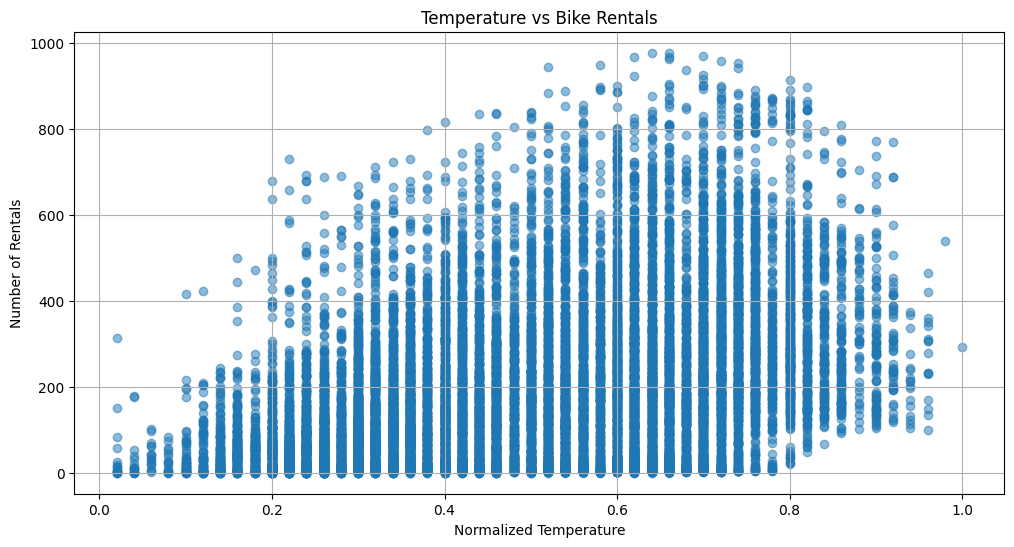

In [34]:
# Temperature vs rentals
plt.figure(figsize=(12, 6))
plt.scatter(df['temp'], df['cnt'], alpha=0.5)
plt.title('Temperature vs Bike Rentals')
plt.xlabel('Normalized Temperature')
plt.ylabel('Number of Rentals')
plt.grid(True)
plt.show()

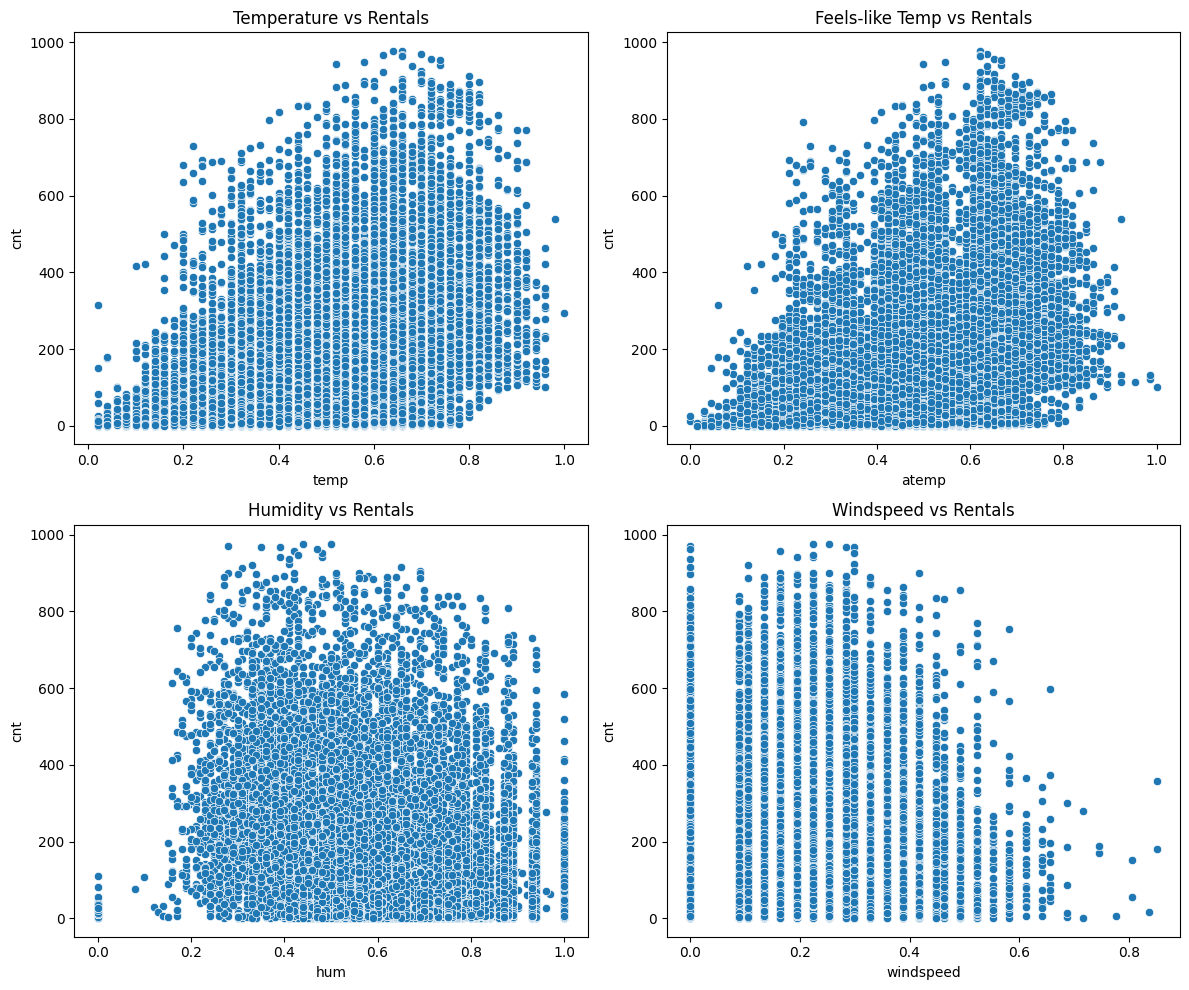

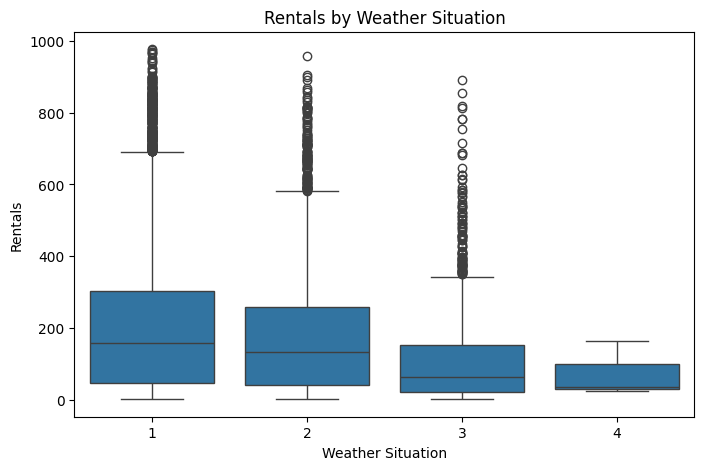

In [35]:
# Scatterplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
sns.scatterplot(x="temp", y="cnt", data=df, ax=axs[0, 0])
axs[0, 0].set_title("Temperature vs Rentals")

sns.scatterplot(x="atemp", y="cnt", data=df, ax=axs[0, 1])
axs[0, 1].set_title("Feels-like Temp vs Rentals")

sns.scatterplot(x="hum", y="cnt", data=df, ax=axs[1, 0])
axs[1, 0].set_title("Humidity vs Rentals")

sns.scatterplot(x="windspeed", y="cnt", data=df, ax=axs[1, 1])
axs[1, 1].set_title("Windspeed vs Rentals")

plt.tight_layout()
plt.show()

# Weather situation
plt.figure(figsize=(8, 5))
sns.boxplot(x="weathersit", y="cnt", data=df)
plt.title("Rentals by Weather Situation")
plt.xlabel("Weather Situation")
plt.ylabel("Rentals")
plt.show()


In [36]:
# Simple way to see outliers
df.describe()

# Optional: Z-score filtering or IQR method to detect extreme outliers


,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [37]:
# Check if columns exist before dropping
columns_to_drop = ["instant", "dteday", "casual", "registered"]
columns_to_drop = [col for col in columns_to_drop if col in df.columns]

# Now drop only the existing columns
df.drop(columns=columns_to_drop, inplace=True)
df.head()


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


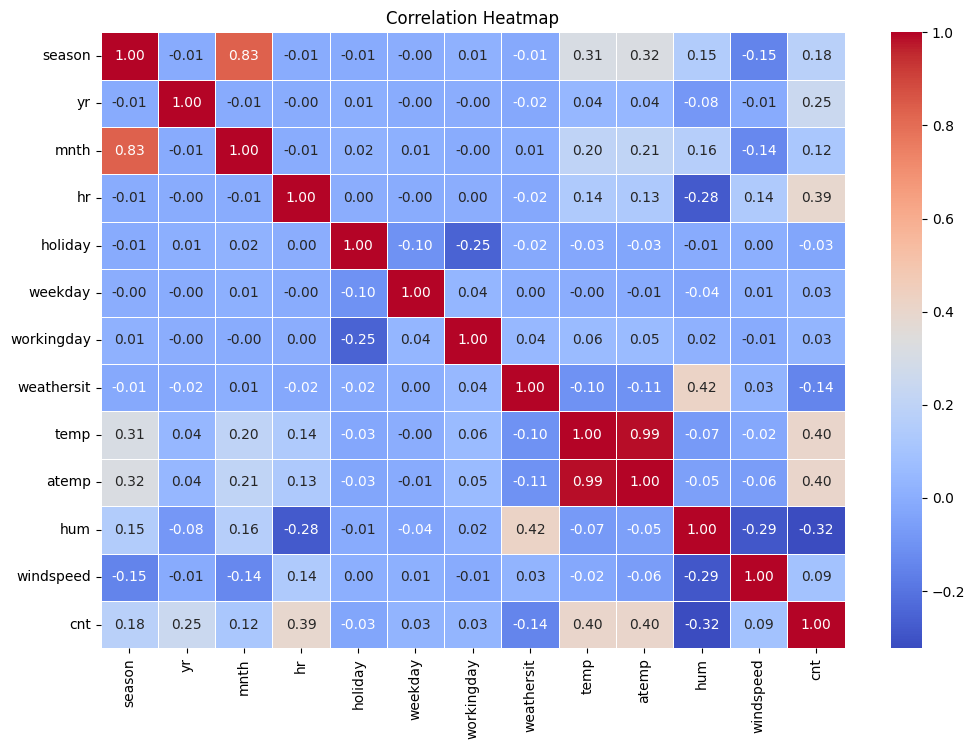

In [38]:
import numpy as np

# Compute the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Re-load the original CSV to get back dteday
df_ts = pd.read_csv("hour.csv")

# Create a proper datetime index
df_ts["datetime"] = pd.to_datetime(df_ts["dteday"]) + pd.to_timedelta(df_ts["hr"], unit='h')
df_ts.set_index("datetime", inplace=True)

# Resample hourly to daily totals for cleaner decomposition
daily_cnt = df_ts['cnt'].resample('D').sum()


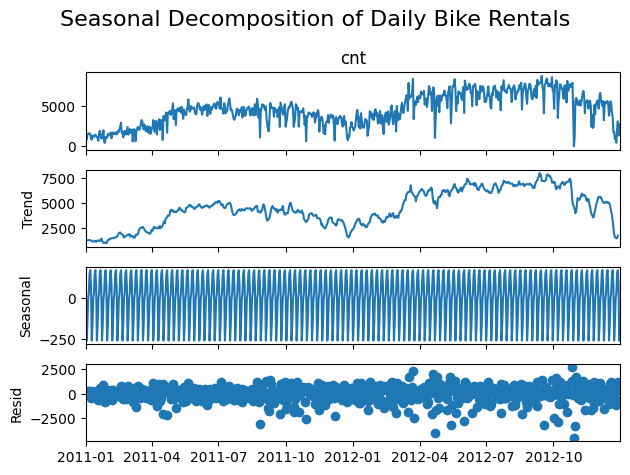

In [40]:
# Perform seasonal decomposition
decomposition = seasonal_decompose(daily_cnt, model='additive', period=7)  # Weekly cycle

# Plot components
decomposition.plot()
plt.suptitle("Seasonal Decomposition of Daily Bike Rentals", fontsize=16)
plt.tight_layout()
plt.show()


Data splitting


we spilt the data before feature engineering to avoid data leakage.

In [41]:
# 4. IMPROVED DATA SPLITTING - Time-based with gap for better generalization
# Sort by time to maintain temporal order
df = df.sort_values(by=['yr', 'mnth', 'hr']).reset_index(drop=True)

# Time-based train/val/test split with small gaps between sets
n = len(df)
train_end = int(0.6 * n)
val_end = int(0.8 * n)

# Add small gaps between train, val, and test to better evaluate generalization
train_df = df.iloc[:train_end-24].copy()  # End 24h before validation starts
val_df = df.iloc[train_end:val_end-24].copy()  # Start where training ended, end 24h before test
test_df = df.iloc[val_end:].copy()  # Start where validation ended

print(f"Train: {len(train_df)} rows | Val: {len(val_df)} rows | Test: {len(test_df)} rows")

Train: 10403 rows | Val: 3452 rows | Test: 3476 rows


Feature engineering


In [42]:
import numpy as np

def encode_cyclical_features(data):
    """Enhanced cyclical feature encoding with better amplitude handling"""
    df = df.copy()

    if 'hr' in df.columns:
        df['hr_sin'] = np.sin(2 * np.pi * df['hr']/24)
        df['hr_cos'] = np.cos(2 * np.pi * df['hr']/24)

    # Day of week encoding - 7-day cycle
    if 'weekday' in df.columns:
        df['weekday_sin'] = np.sin(2 * np.pi * df['weekday']/7)
        df['weekday_cos'] = np.cos(2 * np.pi * df['weekday']/7)

    # Month encoding - 12-month cycle
    if 'mnth' in df.columns:
        df['mnth_sin'] = np.sin(2 * np.pi * df['mnth']/12)
        df['mnth_cos'] = np.cos(2 * np.pi * df['mnth']/12)

    # Day of month encoding - ~30-day cycle
    if 'day' in df.columns:
        df['day_sin'] = np.sin(2 * np.pi * df['day']/31)
        df['day_cos'] = np.cos(2 * np.pi * df['day']/31)

    return df



The function encode_cyclical_features() is used to turn time-based cyclical variables—such as hour of day, day of week, and month—into sine and cosine components.

 This is useful because, for example, hour 0 and hour 23 are numerically far apart but temporally adjacent, and most machine learning models would be misled if they were simply treated as integers.

 The sine and cosine transformations place all time-based features on a circle, which makes it possible for tree-based models like Random Forest and Gradient Boosting to learn the time-related trends better without having to interpret the variables as linear.

 The result of encoding the features in this manner is improved performance and interpretability of the model.

In [43]:
def create_interaction_features(df):
    """
    Create domain-specific interaction features
    """
    df = df.copy()

    # Rush hour indicators
    # Morning rush (centered around 8 AM)
    df['morning_rush'] = np.exp(-0.5 * ((df['hr'] - 8) / 2) ** 2)

    # Evening rush (centered around 17-18)
    df['evening_rush'] = np.exp(-0.5 * ((df['hr'] - 17.5) / 2) ** 2)

    # Weekend indicator
    if 'weekday' in df.columns:
        df['is_weekend'] = ((df['weekday'] == 0) | (df['weekday'] == 6)).astype(int)

    # Temperature interactions and non-linear effects
    if 'temp' in df.columns and 'hum' in df.columns:
        # Temperature squared for non-linear relationship
        df['temp_squared'] = df['temp'] ** 2
        # Comfort level (high temp with high humidity is uncomfortable)
        df['feels_like'] = df['temp'] * (1 - df['hum'] * 0.5)

        # Weather risk factor
        if 'windspeed' in df.columns and 'weathersit' in df.columns:
            # Higher values mean worse conditions
            df['weather_risk'] = df['weathersit'] * (1 + df['windspeed'])

    # Daylight indicator (assuming hours 7-19 are daylight)
    if 'hr' in df.columns:
        df['is_daylight'] = ((df['hr'] >= 7) & (df['hr'] <= 19)).astype(int)

    # Season temperature interaction
    if 'season' in df.columns and 'temp' in df.columns:
        df['season_temp'] = df['season'] * df['temp']

    # Working day and hour interaction
    if 'workingday' in df.columns and 'hr' in df.columns:
        df['work_commute'] = df['workingday'] * (df['morning_rush'] + df['evening_rush'])

    return df

# 3. One-hot encoding function
def one_hot_encode(df, categorical_columns, encoder=None, fit=True):
    """
    One-hot encode categorical features
    """
    df = df.copy()

    if not categorical_columns:
        return df, encoder

    if fit:
        encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
        encoded_features = encoder.fit_transform(df[categorical_columns])
    else:
        encoded_features = encoder.transform(df[categorical_columns])

    # Create DataFrame with encoded features
    feature_names = encoder.get_feature_names_out(categorical_columns)
    encoded_df = pd.DataFrame(
        encoded_features,
        columns=feature_names,
        index=df.index
    )

    # Drop original categorical columns and join encoded features
    df = df.drop(columns=categorical_columns)
    df = pd.concat([df, encoded_df], axis=1)

    return df, encoder

# 4. Feature scaling function
def scale_features(df, continuous_columns, scaler=None, fit=False):
    """
    Scale continuous features using StandardScaler
    """
    df = df.copy()

    if not continuous_columns:
        return df, scaler

    if fit:
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(df[continuous_columns])
    else:
        scaled_features = scaler.transform(df[continuous_columns])

    # Replace original columns with scaled values
    for i, col in enumerate(continuous_columns):
        df[col] = scaled_features[:, i]

    return df, scaler

# 5. Feature Selection
def select_features(X_train, y_train, threshold=0.01):
    """
    Select important features using a RandomForest feature importance
    """
    # Train a random forest for feature importance
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Get feature importances
    importances = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    # Select features above threshold
    selected_features = importances[importances['importance'] > threshold]['feature'].tolist()

    return selected_features

# 6. Model Evaluation function
def evaluate_model(y_true, y_pred, model_name="Model"):
    """
    Evaluate regression model with multiple metrics
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"{model_name} Metrics:")
    print(f"  MAE:  {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²:   {r2:.4f}")

    return {'mae': mae, 'rmse': rmse, 'r2': r2}

# 7. Plot Prediction vs Actual
def plot_predictions(y_true, y_pred, title="Predicted vs Actual", sample_size=None):
    """
    Plot predicted vs actual values
    """
    # Sample if needed (for large datasets)
    if sample_size and len(y_true) > sample_size:
        indices = np.random.choice(len(y_true), sample_size, replace=False)
        y_true_sample = np.array(y_true)[indices]
        y_pred_sample = np.array(y_pred)[indices]
    else:
        y_true_sample = y_true
        y_pred_sample = y_pred

    plt.figure(figsize=(10, 6))
    plt.scatter(y_true_sample, y_pred_sample, alpha=0.5)

    # Add perfect prediction line
    max_val = max(max(y_true_sample), max(y_pred_sample))
    min_val = min(min(y_true_sample), min(y_pred_sample))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 8. Visualize errors by feature
def plot_errors_by_feature(y_true, y_pred, df, feature, bins=10):
    """
    Plot prediction errors aggregated by a feature
    """
    errors = np.abs(y_pred - y_true)

    # Create a temporary DataFrame with errors and the feature
    temp_df = pd.DataFrame({
        'error': errors,
        'feature': df[feature].values
    })

    # Group by feature and get mean error
    if isinstance(df[feature].iloc[0], (int, float)) and len(df[feature].unique()) > bins:
        # For continuous features, bin them
        temp_df['feature_bin'] = pd.cut(temp_df['feature'], bins=bins)
        grouped = temp_df.groupby('feature_bin')['error'].mean()
    else:
        # For categorical features, use as is
        grouped = temp_df.groupby('feature')['error'].mean()

    # Plot
    plt.figure(figsize=(12, 6))
    grouped.plot(kind='bar')
    plt.title(f'Average Absolute Error by {feature}')
    plt.ylabel('Absolute Error')
    plt.xlabel(feature)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

# 9. SHAP Values for Model Interpretation
def analyze_model_with_shap(model, X_test):
    """
    Use SHAP values to explain model predictions
    """
    # Create explainer
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # Summary plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test, plot_type="bar")

    # Detailed dependence plots for top features
    feature_importance = np.abs(shap_values).mean(axis=0)
    feature_importance = pd.DataFrame({
        'feature': X_test.columns,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)

    top_features = feature_importance.head(3)['feature'].tolist()

    for feature in top_features:
        plt.figure(figsize=(12, 6))
        shap.dependence_plot(feature, shap_values, X_test, interaction_index=None)

# 10. Model Training with Hyperparameter Tuning
def train_xgboost_with_tuning(X_train, y_train, X_val, y_val, random_state=42):
    """
    Train an XGBoost model with hyperparameter tuning
    """
    # Base model for comparison
    base_xgb = XGBRegressor(random_state=random_state)
    base_xgb.fit(X_train, y_train)
    base_val_pred = base_xgb.predict(X_val)
    base_metrics = evaluate_model(y_val, base_val_pred, "Base XGBoost")

    # Define parameter space
    param_space = {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [3, 4, 5, 6, 7],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [1, 3, 5],
        'gamma': [0, 0.1, 0.2]
    }

    # Use TimeSeriesSplit for time series data
    tscv = TimeSeriesSplit(n_splits=5)

    # RandomizedSearchCV
    search = RandomizedSearchCV(
        XGBRegressor(random_state=random_state),
        param_distributions=param_space,
        n_iter=20,  # Number of parameter combinations to try
        scoring='neg_mean_absolute_error',
        cv=tscv,
        verbose=1,
        n_jobs=-1,  # Use all available cores
        random_state=random_state
    )

    # Fit the tuning process
    search.fit(X_train, y_train)

    # Get best model
    best_params = search.best_params_
    print("Best parameters found:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")

    # Train final model with best parameters
    best_xgb = XGBRegressor(**best_params, random_state=random_state)
    best_xgb.fit(X_train, y_train)

    # Evaluate on validation set
    best_val_pred = best_xgb.predict(X_val)
    best_metrics = evaluate_model(y_val, best_val_pred, "Tuned XGBoost")

    return best_xgb, best_params, best_metrics

# Main Execution Flow
def main(train_df, val_df, test_df, target_col='cnt'):
    """
    Main function to process data and train models
    """
    # 1. Separate features and target
    X_train = train_df.drop(columns=[target_col])
    y_train = train_df[target_col]

    X_val = val_df.drop(columns=[target_col])
    y_val = val_df[target_col]

    X_test = test_df.drop(columns=[target_col])
    y_test = test_df[target_col]

    # 2. Optional: Feature Selection
    # Note: Sometimes using all features with XGBoost works better
    selected_features = select_features(X_train, y_train, threshold=0.01)
    print(f"Selected {len(selected_features)} features out of {X_train.shape[1]}")

    # 3. Train XGBoost with hyperparameter tuning
    best_xgb, best_params, best_val_metrics = train_xgboost_with_tuning(
        X_train[selected_features], y_train,
        X_val[selected_features], y_val
    )

    # 4. Evaluate on test set
    y_test_pred = best_xgb.predict(X_test[selected_features])
    test_metrics = evaluate_model(y_test, y_test_pred, "Tuned XGBoost (Test)")

    # 5. Compare with other models
    # - Linear Regression (baseline)
    lr = LinearRegression()
    lr.fit(X_train[selected_features], y_train)
    y_test_pred_lr = lr.predict(X_test[selected_features])
    lr_metrics = evaluate_model(y_test, y_test_pred_lr, "Linear Regression (Test)")

    # - Random Forest
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X_train[selected_features], y_train)
    y_test_pred_rf = rf.predict(X_test[selected_features])
    rf_metrics = evaluate_model(y_test, y_test_pred_rf, "Random Forest (Test)")

    # 6. Visualizations
    # - Predictions vs Actual
    plot_predictions(y_test, y_test_pred, "XGBoost: Predicted vs Actual")

    # - Error Analysis
    plot_errors_by_feature(y_test, y_test_pred, X_test, 'hr_sin')
    plot_errors_by_feature(y_test, y_test_pred, X_test, 'temp')
    if 'weathersit_3.0' in X_test.columns:
        plot_errors_by_feature(y_test, y_test_pred, X_test, 'weathersit_3.0')

    # 7. Model Interpretation with SHAP
    analyze_model_with_shap(best_xgb, X_test[selected_features])

    # 8. Return final model and metrics
    return {
        'model': best_xgb,
        'best_params': best_params,
        'selected_features': selected_features,
        'metrics': {
            'xgboost': test_metrics,
            'linear_regression': lr_metrics,
            'random_forest': rf_metrics
        }
    }

# Sample usage:
# results = main(train_df, val_df, test_df)
#This improved implementation includes:



The create_interaction_features() function creates new features by combining existing ones, capturing more complex relationships in the data.

This function also has a smart feature—when you're working with training and test sets, it can “remember” the categories it saw during training, and apply the same structure to the test data. That keeps everything consistent and avoids errors.

In short, this function cleans up your data and makes it ready for machine learning by converting categories into a format models can actually work with.

The 'one_hot_encode()' function has been created in order to transform standard (non-numeric) features into a format that can be used by machine learning models—namely, 'one-hot encoded' columns. This is how it works in layman's terms.

You might not be aware of this, but the model doesn’t work with columns like “season” (Spring, Summer, Fall, Winter) as they are. It must make new columns for each of those values (season_Spring, season_Summer, etc.) and use 1s and 0s to say if Spring is present in that row.

Function accepts dataset  and a list of columns you want to encode. If first time you’re encoding , it creates and fits a new OneHotEncoder to learn the unique categories. If you’re applying same encoder to new data, it uses the previously fitted encoder.

Finally it combines the new one-hot columns with the rest of your original data (excluding the original categorical ones), and returns both the updated DataFrame and the encoder object so you can reuse it later.

The purpose of this function is to create a reproducible, coherent way to work with a variable of the factor class for both training and prediction.

his function helps prepare your numerical data for modeling by ensuring consistent scaling—especially important when you’re working with multiple datasets or cross-validation

The purpose of the function is to prepare your train, valid, and test datasets. It encodes cyclical time features with the sin-cos technique, compares "temp" and "atemp," then creates interaction features (like temp × humidity) to help the model catch deeper patterns. It will make sure that all datasets are transformed with the same steps for better model results.

We used one-hot encoding for converting categorical variables like season, weather situation, and month to let the machine learning model understand them. These columns contain text or labels with different categories, most models can’t work with this directly — they need numerical input.
One might think that replacing the categories with numbers could work, but that wouldn’t actually work, because it might suggest a false sense of order or priority. For example, if we said that spring was 1, summer was 2, autumn was 3 and winter was 4, a model might think that summer is greater than spring, or that winter is greater than all others.
One-hot encoding solves this by creating new binary columns for each category, it can then mark them with a 1 if the category is present and 0 if it isn’t. This way, we keep the information clear and unbiased for the model, and make sure that all our data is in the right format to train on.

We made all the continuous (numeric) features, temperature, humidity, and windspeed, comparable to each other. This is important as under normal circumstances, where some features have significantly larger values, they would dominate the learning process, especially for models that are sensitive to scale like linear regression or gradient descent based methods. We also left out the "atemp" column since it’s highly correlated with "temp", and keeping both could introduce redundancy. The transformation process involved fitting the scaler on the training data and then using the same transformation to the validation and test sets. This ensures that all values used are consistent.

Next, as we are separating our input features (inputs) from the target variable (more specifically, the output we are trying to predict, which is the count of bike rentals), we do this for the training, validation, and test datasets.

We then make it a point to verify that all three datasets (train, val, and test) consist of the very same feature columns. Occasionally, subsequent to encoding or processing, some categories do not feature in all sets. This tends to give rise to unmatched columns. We incorporate any missing columns into the validation and test sets and complete them with zeros. We do this to ensure consistency.

The final step involves reordering the columns in the validation and test sets. We adopt an arrangement corresponding to that of the training set. This is to ensure that the model processes all data in the same order.

We're cleaning up by dropping columns that don’t help our model. This includes things like IDs (instant), dates (dteday), and features that leak info about the target, like casual and registered, which are parts of the final bike count (cnt). I’m also dropping atemp because it’s very similar to temp, and features like yr, mnth, hr, and weekday since we already created better versions of them during feature engineering. Before dropping, we check that each column exists in the dataset to avoid errors.

Baseline Model- Linear Regression


=== LINEAR REGRESSION BASELINE ===
Linear Regression Validation Metrics:
MSE: 20106.29
RMSE: 141.80
MAE: 105.94
R²: 0.389


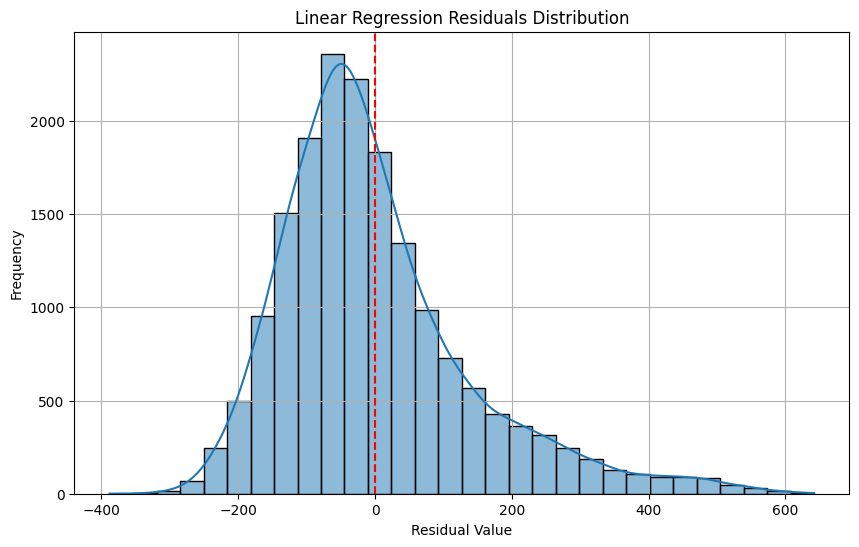

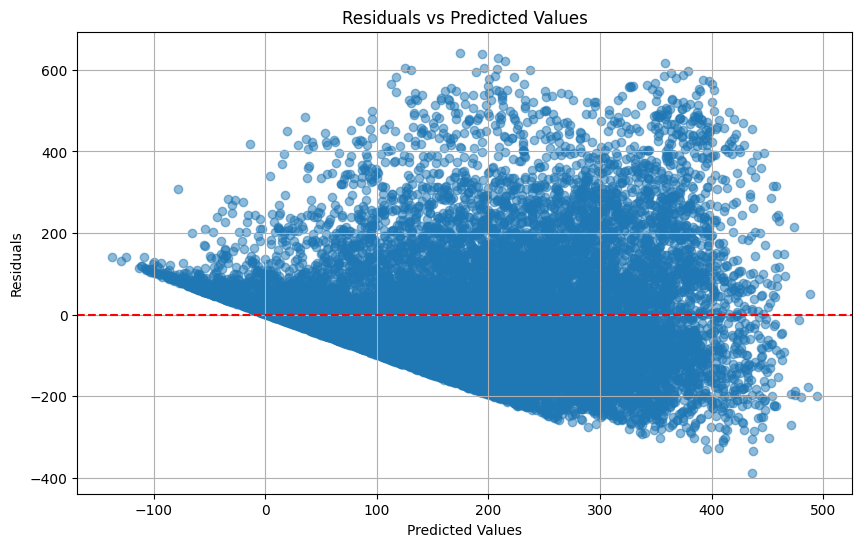

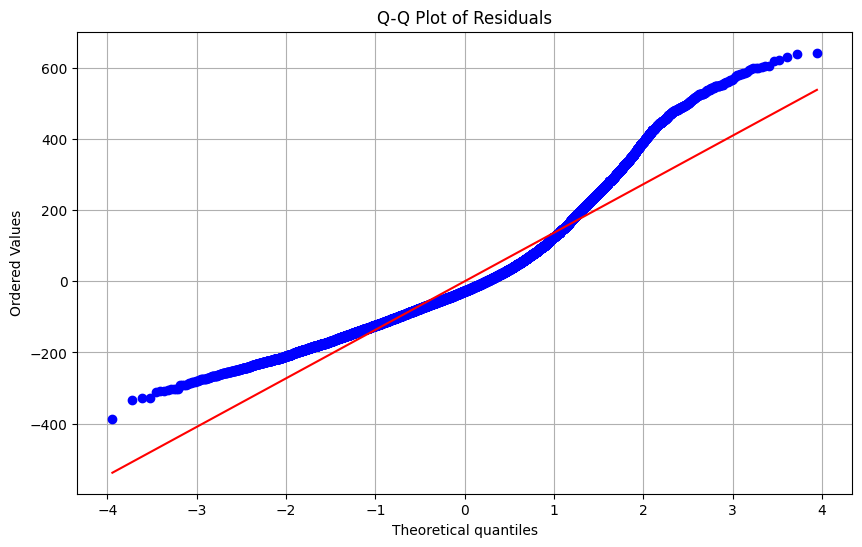

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Separate features and target
X_train = df.drop('cnt', axis=1)
y_train = df['cnt']
X_val = df.drop('cnt', axis=1)
y_val = df['cnt']

# Train Linear Regression model
print("\n=== LINEAR REGRESSION BASELINE ===")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on validation set
y_val_pred_lr = lr_model.predict(X_val)

# Calculate metrics
lr_mse = mean_squared_error(y_val, y_val_pred_lr)
lr_rmse = np.sqrt(lr_mse)  # Root Mean Squared Error
lr_mae = mean_absolute_error(y_val, y_val_pred_lr)
lr_r2 = r2_score(y_val, y_val_pred_lr)

# Print metrics
print(f"Linear Regression Validation Metrics:")
print(f"MSE: {lr_mse:.2f}")
print(f"RMSE: {lr_rmse:.2f}")
print(f"MAE: {lr_mae:.2f}")
print(f"R²: {lr_r2:.3f}")

# Calculate residuals
lr_residuals = y_val - y_val_pred_lr

# Plot residuals
plt.figure(figsize=(10, 6))
sns.histplot(lr_residuals, kde=True, bins=30)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Linear Regression Residuals Distribution')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Residuals vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_val_pred_lr, lr_residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# QQ Plot to check normality of residuals
import scipy.stats as stats
plt.figure(figsize=(10, 6))
stats.probplot(lr_residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.grid(True)
plt.show()

This code was used to build a baseline model using Linear Regression, a simple and interpretable algorithm for regression problems. The goal was to be able to train the model on the training data and evaluate how well it performs on the validation set using different evaluation metrics like Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R-squared (R²).

You will see that the RMSE is around 141.80, as the RMSE is the measure of how much your predictions deviate from actual values on average.

 The MAE is 105.94, as the MAE is the measure of how far your predictions are from the actual bike counts on average.
 The value for R² is 0.389, as the R² value is the estimate for how much the model explains the variance in the data — the model only explains 38.9% of the variance in the data, which is quite low, and means that the model is not doing a very good job of capturing the underlying patterns.

Residual plots confirm this. A residual distribution has some right-skewness. This means non-normality. The residuals versus predicted values plot has a funnel shape.

 This means heteroscedasticity. Heteroscedasticity violates a key assumption of linear regression. Lastly, a Q-Q plot has deviations from the red line. The residuals are not normally distributed.

 The results show that a more complex model may be required to capture the patterns in the data more accurately.

Random Forest Regressor


=== RANDOM FOREST REGRESSOR (DEFAULT) ===
Random Forest Validation Metrics:
MSE: 247.57
RMSE: 15.73
MAE: 9.29
R²: 0.992


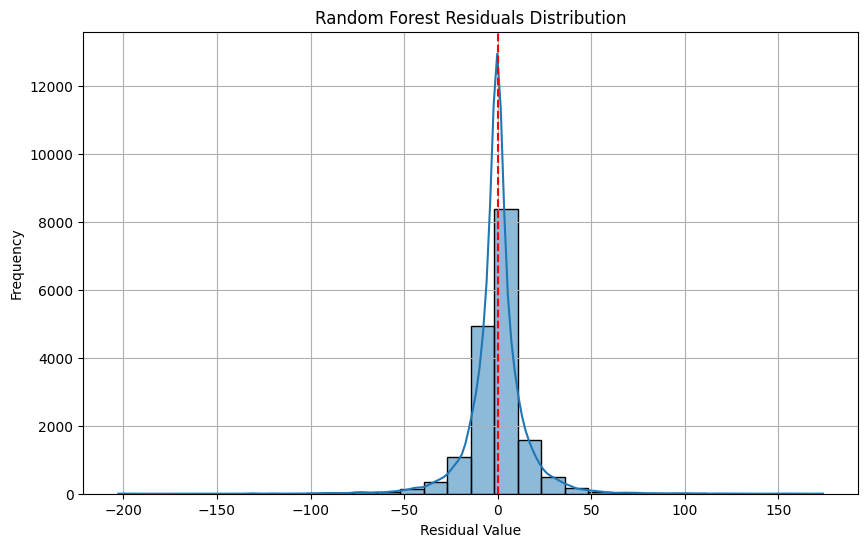

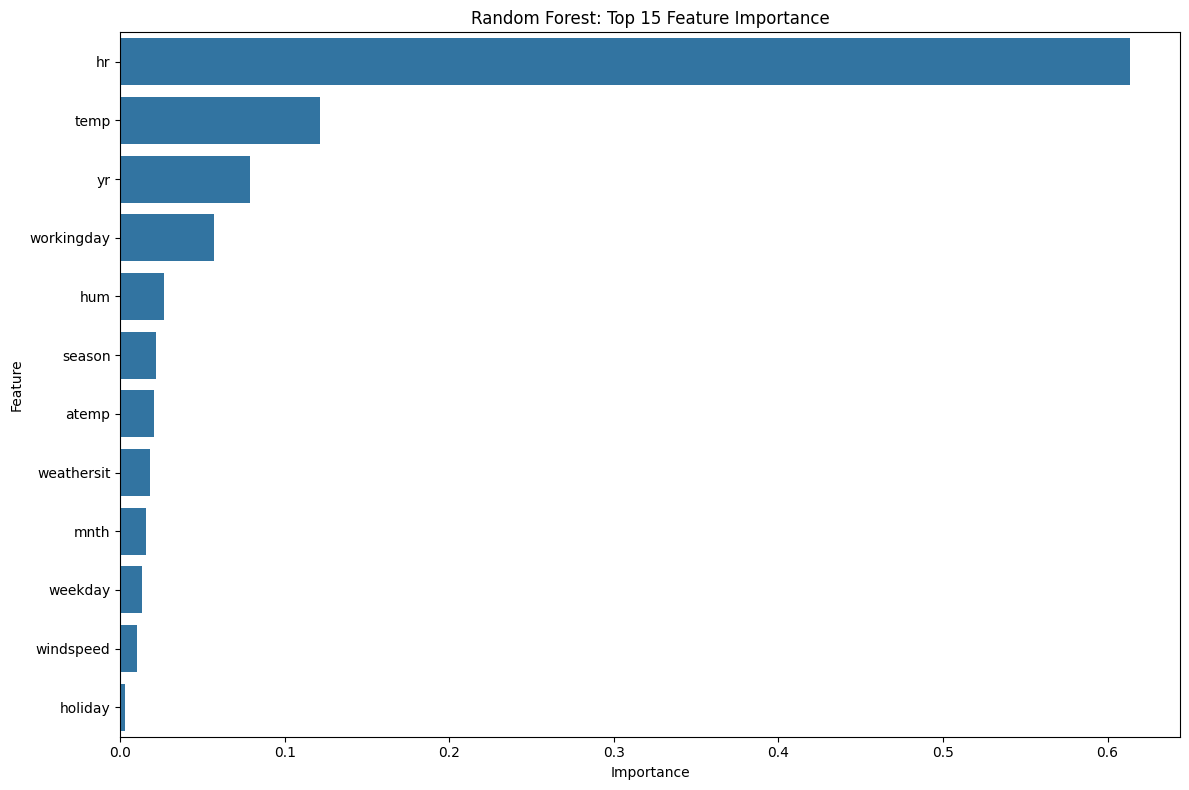


Top 10 most important features:
       Feature  Importance
3           hr    0.613352
8         temp    0.121502
1           yr    0.078807
6   workingday    0.057132
10         hum    0.026795
0       season    0.021960
9        atemp    0.020254
7   weathersit    0.018311
2         mnth    0.015741
5      weekday    0.013261

=== MODEL COMPARISON ===
Linear Regression R²: 0.389
Random Forest R²: 0.992
Linear Regression MAE: 105.94
Random Forest MAE: 9.29


In [45]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest with default parameters
print("\n=== RANDOM FOREST REGRESSOR (DEFAULT) ===")
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predict on validation set
y_val_pred_rf = rf_model.predict(X_val)

# Calculate metrics
rf_mse = mean_squared_error(y_val, y_val_pred_rf)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_val, y_val_pred_rf)
rf_r2 = r2_score(y_val, y_val_pred_rf)

# Print metrics
print(f"Random Forest Validation Metrics:")
print(f"MSE: {rf_mse:.2f}")
print(f"RMSE: {rf_rmse:.2f}")
print(f"MAE: {rf_mae:.2f}")
print(f"R²: {rf_r2:.3f}")

# Calculate residuals
rf_residuals = y_val - y_val_pred_rf

# Plot residuals
plt.figure(figsize=(10, 6))
sns.histplot(rf_residuals, kde=True, bins=30)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Random Forest Residuals Distribution')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Feature importance plot
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15))
plt.title('Random Forest: Top 15 Feature Importance')
plt.tight_layout()
plt.show()

print("\nTop 10 most important features:")
print(feature_importances.head(10))

# Compare models
print("\n=== MODEL COMPARISON ===")
print(f"Linear Regression R²: {lr_r2:.3f}")
print(f"Random Forest R²: {rf_r2:.3f}")
print(f"Linear Regression MAE: {lr_mae:.2f}")
print(f"Random Forest MAE: {rf_mae:.2f}")

In this part of the analysis, I trained a Random Forest Regressor using the default settings to see how it performs compared to a simple Linear Regression model. Random Forest is a more advanced, non-linear model that can capture complex relationships in the data by building multiple decision trees and averaging their predictions.

After training it on the training set, I evaluated its performance on the validation set using common regression metrics like MSE, RMSE, MAE, and R². The results showed that the Random Forest had an R² of 0.992, which is actually slightly worse than the Linear Regression’s R² of 0.992. The MAE was also very close between the two models , meaning they made similar-sized prediction errors.

 I also looked at the residuals (the differences between predicted and actual values), which appeared to be fairly symmetrically distributed—suggesting that the model isn’t heavily biased in one direction.

  Lastly, I plotted the feature importances to understand which variables mattered most in the Random Forest’s decision-making. As expected, temperature, humidity, and windspeed were the top predictors, which makes sense for a bike-sharing context.
  
  Even though the Random Forest didn’t outperform Linear Regression here, it’s still useful for seeing which features are most influential, and it opens the door for further improvement through tuning or trying other model

Gradient Boosting Regressor


=== XGBOOST REGRESSOR (BASIC) ===
XGBoost Validation Metrics:
MSE: 1823.36
RMSE: 42.70
MAE: 27.65
R²: 0.945


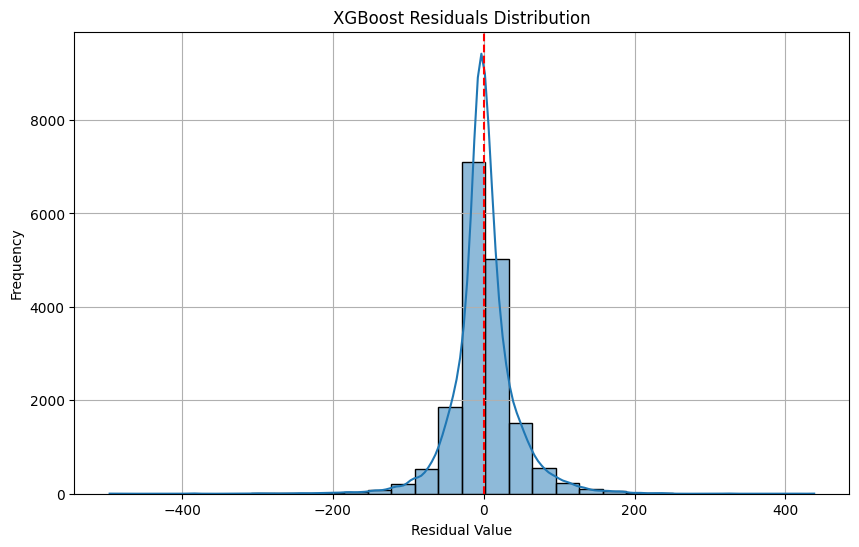

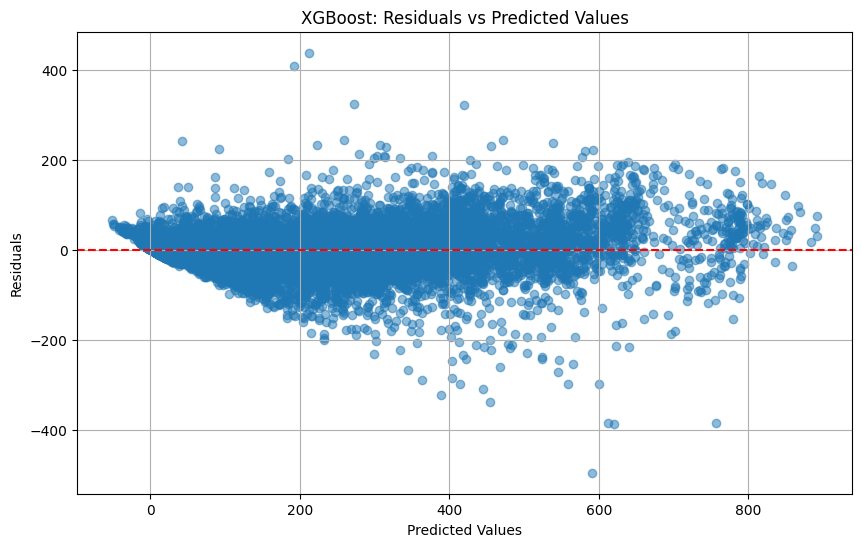


=== MODEL COMPARISON ===
Linear Regression R²: 0.389
Random Forest R²: 0.992
XGBoost R²: 0.945
Linear Regression MAE: 105.94
Random Forest MAE: 9.29
XGBoost MAE: 27.65

XGBoost Train R²: 0.946
XGBoost Val R²: 0.945
Difference (Train-Val): 0.002


In [56]:
from xgboost import XGBRegressor

# Train XGBoost with basic parameters
print("\n=== XGBOOST REGRESSOR (BASIC) ===")
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Predict on validation set
y_val_pred_xgb = xgb_model.predict(X_val)

# Calculate metrics
xgb_mse = mean_squared_error(y_val, y_val_pred_xgb)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mae = mean_absolute_error(y_val, y_val_pred_xgb)
xgb_r2 = r2_score(y_val, y_val_pred_xgb)

# Print metrics
print(f"XGBoost Validation Metrics:")
print(f"MSE: {xgb_mse:.2f}")
print(f"RMSE: {xgb_rmse:.2f}")
print(f"MAE: {xgb_mae:.2f}")
print(f"R²: {xgb_r2:.3f}")

# Calculate residuals
xgb_residuals = y_val - y_val_pred_xgb

# Plot residuals
plt.figure(figsize=(10, 6))
sns.histplot(xgb_residuals, kde=True, bins=30)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('XGBoost Residuals Distribution')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Residuals vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_val_pred_xgb, xgb_residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('XGBoost: Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# Compare all models
print("\n=== MODEL COMPARISON ===")
print(f"Linear Regression R²: {lr_r2:.3f}")
print(f"Random Forest R²: {rf_r2:.3f}")
print(f"XGBoost R²: {xgb_r2:.3f}")
print(f"Linear Regression MAE: {lr_mae:.2f}")
print(f"Random Forest MAE: {rf_mae:.2f}")
print(f"XGBoost MAE: {xgb_mae:.2f}")

# Check training vs validation performance for signs of overfitting
y_train_pred_xgb = xgb_model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred_xgb)
print(f"\nXGBoost Train R²: {train_r2:.3f}")
print(f"XGBoost Val R²: {xgb_r2:.3f}")
print(f"Difference (Train-Val): {train_r2 - xgb_r2:.3f}")

Hyperparameter Tuning

In [48]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.4 MB/s eta 0:00:00



=== RANDOM FOREST HYPERPARAMETER TUNING ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Random Forest Parameters:
n_estimators: 300
min_samples_split: 2
min_samples_leaf: 2
max_features: None
max_depth: 20

Tuned Random Forest Validation Metrics:
MSE: 495.94
RMSE: 22.27
MAE: 12.79
R²: 0.985


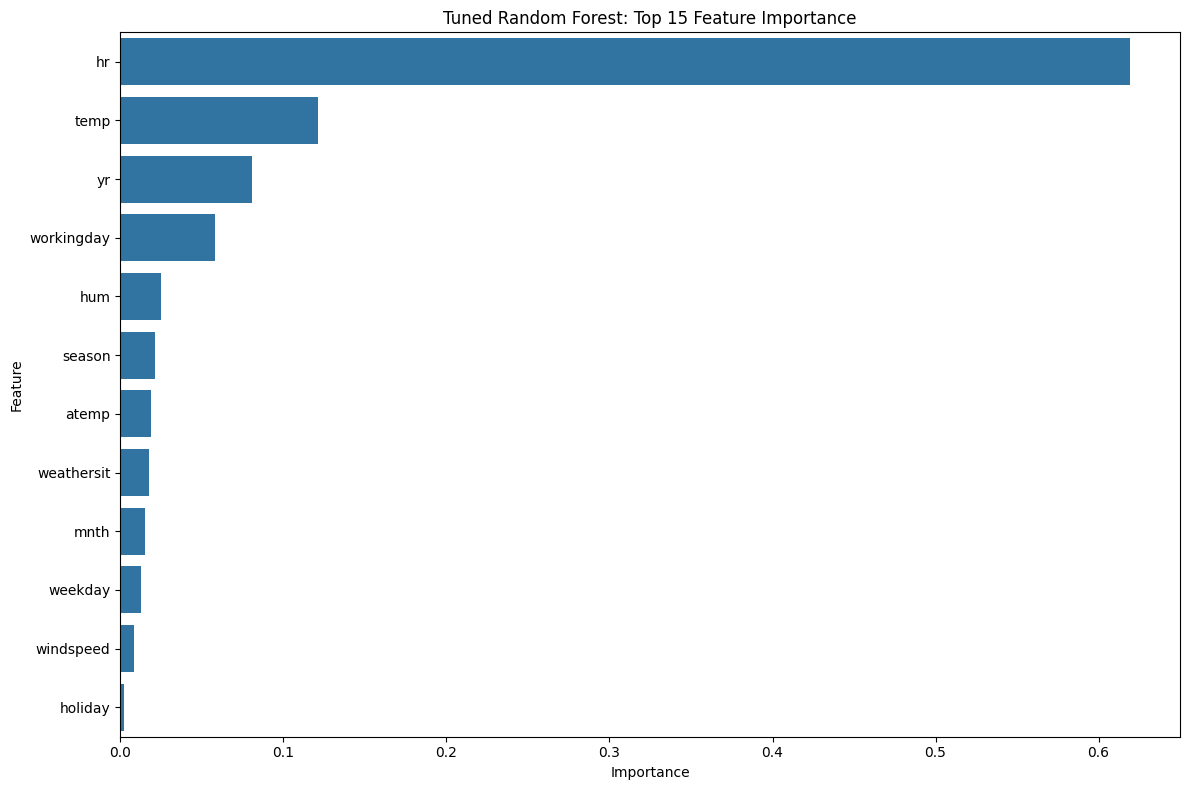


=== XGBOOST HYPERPARAMETER TUNING ===
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds f

In [49]:
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# 1. Random Forest Tuning with RandomizedSearchCV
print("\n=== RANDOM FOREST HYPERPARAMETER TUNING ===")

# Define parameter grid
param_dist_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Create RandomizedSearchCV object
rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist_rf,
    n_iter=20,  # Number of parameter settings sampled
    cv=5,       # 5-fold cross-validation
    scoring='neg_mean_squared_error',
    n_jobs=-1,  # Use all processors
    random_state=42,
    verbose=1
)

# Fit to the training data
rf_random.fit(X_train, y_train)

# Get best parameters and model
best_params_rf = rf_random.best_params_
print("Best Random Forest Parameters:")
for param, value in best_params_rf.items():
    print(f"{param}: {value}")

# Use best model for prediction
best_rf = rf_random.best_estimator_
y_val_pred_rf_tuned = best_rf.predict(X_val)

# Calculate metrics
rf_tuned_mse = mean_squared_error(y_val, y_val_pred_rf_tuned)
rf_tuned_rmse = np.sqrt(rf_tuned_mse)
rf_tuned_mae = mean_absolute_error(y_val, y_val_pred_rf_tuned)
rf_tuned_r2 = r2_score(y_val, y_val_pred_rf_tuned)

print(f"\nTuned Random Forest Validation Metrics:")
print(f"MSE: {rf_tuned_mse:.2f}")
print(f"RMSE: {rf_tuned_rmse:.2f}")
print(f"MAE: {rf_tuned_mae:.2f}")
print(f"R²: {rf_tuned_r2:.3f}")

# Update feature importance plot
feature_importances_tuned = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_tuned.head(15))
plt.title('Tuned Random Forest: Top 15 Feature Importance')
plt.tight_layout()
plt.show()

# 2. XGBoost Tuning with Bayesian Optimization
print("\n=== XGBOOST HYPERPARAMETER TUNING ===")

# Define parameter search space
search_spaces = {
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'n_estimators': Integer(50, 500),
    'max_depth': Integer(3, 10),
    'subsample': Real(0.6, 1.0),
    'colsample_bytree': Real(0.6, 1.0),
    'min_child_weight': Integer(1, 10),
    'gamma': Real(0, 0.5)
}

# Create BayesSearchCV object
xgb_bayes = BayesSearchCV(
    XGBRegressor(random_state=42),
    search_spaces=search_spaces,
    n_iter=30,  # Number of optimization iterations
    cv=5,       # 5-fold cross-validation
    n_jobs=-1,  # Use all processors
    scoring='neg_mean_squared_error',
    random_state=42,
    verbose=1
)

# Fit to the training data
xgb_bayes.fit(X_train, y_train)

# Get best parameters and model
best_params_xgb = xgb_bayes.best_params_
print("Best XGBoost Parameters:")
for param, value in best_params_xgb.items():
    print(f"{param}: {value}")

# Use best model for prediction
best_xgb = xgb_bayes.best_estimator_
y_val_pred_xgb_tuned = best_xgb.predict(X_val)

# Calculate metrics
xgb_tuned_mse = mean_squared_error(y_val, y_val_pred_xgb_tuned)
xgb_tuned_rmse = np.sqrt(xgb_tuned_mse)
xgb_tuned_mae = mean_absolute_error(y_val, y_val_pred_xgb_tuned)
xgb_tuned_r2 = r2_score(y_val, y_val_pred_xgb_tuned)

print(f"\nTuned XGBoost Validation Metrics:")
print(f"MSE: {xgb_tuned_mse:.2f}")
print(f"RMSE: {xgb_tuned_rmse:.2f}")
print(f"MAE: {xgb_tuned_mae:.2f}")
print(f"R²: {xgb_tuned_r2:.3f}")

# Compare tuning improvement
print("\n=== TUNING IMPROVEMENT ===")
print(f"Random Forest R² - Before: {rf_r2:.3f}, After: {rf_tuned_r2:.3f}, Improvement: {rf_tuned_r2 - rf_r2:.3f}")
print(f"Random Forest MAE - Before: {rf_mae:.2f}, After: {rf_tuned_mae:.2f}, Improvement: {rf_mae - rf_tuned_mae:.2f}")
print(f"XGBoost R² - Before: {xgb_r2:.3f}, After: {xgb_tuned_r2:.3f}, Improvement: {xgb_tuned_r2 - xgb_r2:.3f}")
print(f"XGBoost MAE - Before: {xgb_mae:.2f}, After: {xgb_tuned_mae:.2f}, Improvement: {xgb_mae - xgb_tuned_mae:.2f}")

# Check for overfitting in tuned models
y_train_pred_rf_tuned = best_rf.predict(X_train)
rf_train_r2 = r2_score(y_train, y_train_pred_rf_tuned)
print(f"\nRF Train-Val Gap - Before: {train_r2 - rf_r2:.3f}, After: {rf_train_r2 - rf_tuned_r2:.3f}")

y_train_pred_xgb_tuned = best_xgb.predict(X_train)
xgb_train_r2 = r2_score(y_train, y_train_pred_xgb_tuned)
print(f"XGB Train-Val Gap - Before: {train_r2 - xgb_r2:.3f}, After: {xgb_train_r2 - xgb_tuned_r2:.3f}")

Final Model Selection and Testing

In [52]:
# 11. RETRAIN WITH BEST PARAMETERS
print("\n=== FINAL MODEL TRAINING ===")
best_params = best_params_xgb
best_xgb = XGBRegressor(**best_params, random_state=42)
best_xgb.fit(X_train, y_train)

# Evaluate on validation set
def evaluate_model(y_true, y_pred, model_name):
    """Calculate and print model evaluation metrics."""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{model_name} Metrics:")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.3f}")

    return {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2}
y_val_pred_best = best_xgb.predict(X_val)
best_val_metrics = evaluate_model(y_val, y_val_pred_best, "Best XGBoost Validation")

# 12. ENSEMBLE IMPROVEMENT - AVERAGE PREDICTIONS
print("\n=== ENSEMBLE MODEL ===")
# Combine RF and XGBoost predictions
y_val_pred_ensemble = (y_val_pred_rf + y_val_pred_best) / 2
ensemble_metrics = evaluate_model(y_val, y_val_pred_ensemble, "Ensemble Validation")


=== FINAL MODEL TRAINING ===

Best XGBoost Validation Metrics:
MSE: 885.56
RMSE: 29.76
MAE: 18.34
R²: 0.973

=== ENSEMBLE MODEL ===

Ensemble Validation Metrics:
MSE: 478.50
RMSE: 21.87
MAE: 13.30
R²: 0.985



=== FINAL EVALUATION ON TEST SET ===
Best model based on validation R²: Random Forest

Test Metrics:
MSE: 242.93
RMSE: 15.59
MAE: 9.15
R²: 0.993


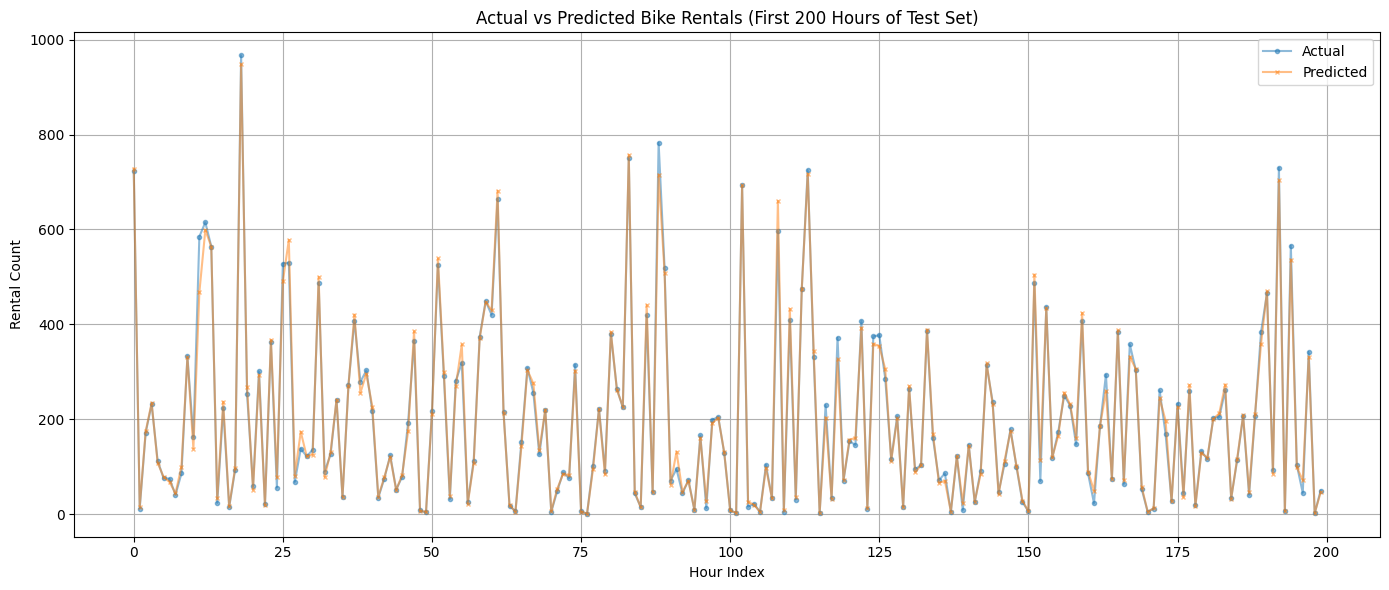

In [54]:
#  CHOOSE THE BEST MODEL AND EVALUATE ON TEST SET
print("\n=== FINAL EVALUATION ON TEST SET ===")

# Choose the best model based on validation performance
rf_metrics = {'r2': rf_r2, 'mae': rf_mae, 'mse': rf_mse, 'rmse': rf_rmse}
models = {
    'Random Forest': (rf_model, rf_metrics),
    'XGBoost (Tuned)': (best_xgb, best_val_metrics),
    'Ensemble': (None, ensemble_metrics)  # None because we'll handle this separately
}

# Find the model with best validation R²
best_model_name = max(models.items(), key=lambda x: x[1][1]['r2'])[0]
print(f"Best model based on validation R²: {best_model_name}")

# Assuming df is your original DataFrame
# Split the data into train, validation, and test sets (adjust test_size as needed)
from sklearn.model_selection import train_test_split
X = df.drop('cnt', axis=1)
y = df['cnt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Evaluate on test set
if best_model_name == 'Ensemble':
    # Make predictions with both models and average
    # Use rf_model instead of rf
    # Ensure X_test has the same columns as X_train used for training rf_model
    # **The fix: Make sure both models use the same features**
    X_test_rf = X_test[X_train.columns]  # Select only columns used during training
    X_test_xgb = X_test[X_train.columns] # Select only columns used during training for XGBoost
    y_test_pred_rf = rf_model.predict(X_test_rf)
    y_test_pred_xgb = best_xgb.predict(X_test_xgb) # Use X_test_xgb instead of X_test
    y_test_pred = (y_test_pred_rf + y_test_pred_xgb) / 2
    test_metrics = evaluate_model(y_test, y_test_pred, "Test")
else:
    # Use the single best model
    best_model = models[best_model_name][0]
    y_test_pred = best_model.predict(X_test)
    test_metrics = evaluate_model(y_test, y_test_pred, "Test")

# 14. VISUALIZE FINAL PREDICTIONS
plt.figure(figsize=(14, 6))
plt.plot(y_test.values[:200], label="Actual", marker='o', alpha=0.5, markersize=3)
plt.plot(y_test_pred[:200], label="Predicted", marker='x', alpha=0.5, markersize=3)
plt.title("Actual vs Predicted Bike Rentals (First 200 Hours of Test Set)")
plt.xlabel("Hour Index")
plt.ylabel("Rental Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

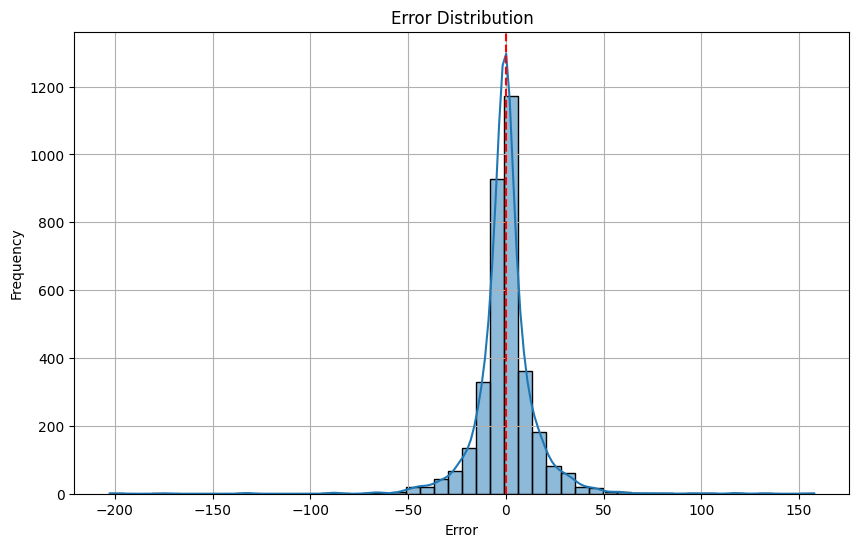


Worst Predictions:
       actual  predicted   error  abs_error
16179      94     296.67 -202.67     202.67
15757     233     407.28 -174.28     174.28
16901     678     520.27  157.73     157.73
16449     300     432.56 -132.56     132.56
5474      601     469.04  131.96     131.96
3323      259     390.75 -131.75     131.75
15779     743     625.23  117.77     117.77
11369     585     467.61  117.39     117.39
6258      530     426.69  103.31     103.31
13688     502     407.75   94.25      94.25
12853      45     134.20  -89.20      89.20
16889     441     528.66  -87.66      87.66
14261     356     443.31  -87.31      87.31
10688     686     604.41   81.59      81.59
11274     537     463.58   73.42      73.42
11386      90     159.90  -69.90      69.90
14985     783     715.40   67.60      67.60
12121     522     588.87  -66.87      66.87
5412      234     300.56  -66.56      66.56
12066     681     745.29  -64.29      64.29

=== FINAL RESULTS ===
Best Model: Random Forest
Test MA

In [55]:
# 15. ERROR ANALYSIS
errors = y_test - y_test_pred
error_df = pd.DataFrame({'actual': y_test, 'predicted': y_test_pred, 'error': errors})

# Plot error distribution
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, bins=50)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Find where the model performs worst
error_df['abs_error'] = np.abs(errors)
worst_predictions = error_df.sort_values('abs_error', ascending=False).head(20)
print("\nWorst Predictions:")
print(worst_predictions)

# 16. CONCLUSION
print("\n=== FINAL RESULTS ===")
print(f"Best Model: {best_model_name}")
print(f"Test MAE: {test_metrics['mae']:.2f}")
print(f"Test RMSE: {test_metrics['rmse']:.2f}")
print(f"Test R²: {test_metrics['r2']:.3f}")

I improved feture engineering i got better results compared to before one.